In [287]:
import itertools as it

import networkx as nx
import numpy as np
from scipy import sparse

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

import matplotlib.pyplot as plt


In [249]:
# utils 

def read_sat(sat_path):
    with open(sat_path) as f:
        sat_lines = f.readlines()
        header = sat_lines[0]
        header_info = header.replace("\n", "").split(" ")
        num_vars = int(header_info[-2])
        num_clauses = int(header_info[-1])

        sat = [[int(x) for x in line.replace(' 0\n', '').split(' ')]
               for line in sat_lines[1:]]

        return sat, num_vars, num_clauses


def sat_to_lig_adjacency_matrix(sat, num_vars):
    get_literal_idx = lambda x: 2 * x - 2 if x > 0 else 2 * abs(x) - 1
    lig_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    lig_weighted_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])

    for clause in sat:
        pairs = it.combinations(clause, 2)
#         print(f'clause: {clause}')
        for pair in pairs:
            x_idx = get_literal_idx(pair[0])
            y_idx = get_literal_idx(pair[1])
#             print(f'pair: {(x_idx, y_idx)}')
            lig_adjacency_matrix[x_idx, y_idx] = 1
            lig_adjacency_matrix[y_idx, x_idx] = 1
            lig_weighted_adjacency_matrix[x_idx, y_idx] += 1
            lig_weighted_adjacency_matrix[y_idx, x_idx] += 1    
    return lig_adjacency_matrix, lig_weighted_adjacency_matrix

In [267]:
class GCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        # GCN initialization
        self.conv1 = GCNConv(node_features, 64)
        self.conv2 = GCNConv(64, 128)
        # self.conv1 = GATConv(node_features, 64, 5)
        # self.conv2 = GATConv(64 * 5, 128)

        # self.conv3 = GCNConv(128, 128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.elu(x)
        # x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        # x = F.tanh(x)
        # x = self.conv3(x, edge_index)
        
        # x1^T * W * x2

        return x


(array([  0,   0,   0, ..., 181, 181, 181]), array([  2,   4,  14, ..., 135, 169, 178]))
tensor([[  0,   0,   0,  ..., 181, 181, 181],
        [  2,   4,  14,  ..., 135, 169, 178]])
[6. 6. 1. ... 2. 1. 3.]
histogram of original weight: (array([1516,  440,   80,   60,   14,   14]), array([1, 2, 3, 4, 5, 6, 7]))


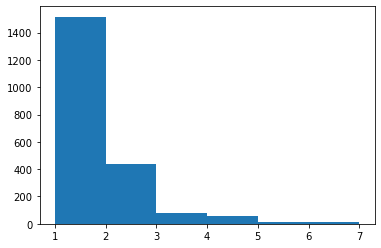

[6. 6. 1. ... 2. 1. 3.]


In [288]:
sat_path = './ssa2670-141.processed.cnf'
sat_instance, num_vars, num_clauses = read_sat(sat_path)

lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
print(lig_adjacency_matrix.nonzero())


# graph = nx.from_numpy_matrix(lig_adjacency_matrix)
# edges = nx.to_edgelist(graph)
# print(lig_adjacency_matrix.nonzero())

edge_index = torch.tensor(lig_adjacency_matrix.nonzero(), dtype=torch.long)
print(edge_index)
edge_value = lig_weighted_adjacency_matrix[lig_adjacency_matrix.nonzero()]
print(edge_value)
print(f'histogram of original weight: {np.histogram(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])}')
plt.hist(edge_value, bins=[1, 2, 3, 4, 5, 6, 7])
plt.show()
# max_edge_value = max(edge_value)
# norm_edge_value = edge_value/max_edge_value
norm_edge_value = edge_value
print(norm_edge_value)

embeddings = torch.load('./embeddings.pt')
embeddings.requires_grad = False
# print(embeddings)
x = embeddings
data = Data(x=x, edge_index=edge_index)


In [269]:
# training
model = GCN(50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    src, dst = edge_index
    score = (out[src] * out[dst]).sum(dim=-1)
    # score = torch.sigmoid(score)
    loss = F.mse_loss(score, torch.tensor(norm_edge_value, dtype=torch.float))
    loss.backward()
    optimizer.step()
    print(f'epoch: {epoch}, loss: {loss.item()}')


# TBD
# 1. product sum 
#

epoch: 0, loss: 1.1641110181808472
epoch: 1, loss: 1.4175746440887451
epoch: 2, loss: 0.7755216956138611
epoch: 3, loss: 2.072573184967041
epoch: 4, loss: 0.7336053252220154
epoch: 5, loss: 0.8084513545036316
epoch: 6, loss: 1.0635331869125366
epoch: 7, loss: 1.1253913640975952
epoch: 8, loss: 1.0059610605239868
epoch: 9, loss: 0.7969239950180054
epoch: 10, loss: 0.686897873878479
epoch: 11, loss: 0.8059244751930237
epoch: 12, loss: 0.8264654874801636
epoch: 13, loss: 0.6877186298370361
epoch: 14, loss: 0.609920859336853
epoch: 15, loss: 0.629022479057312
epoch: 16, loss: 0.6754872798919678
epoch: 17, loss: 0.6977923512458801
epoch: 18, loss: 0.6801174879074097
epoch: 19, loss: 0.6346316933631897
epoch: 20, loss: 0.5933061242103577
epoch: 21, loss: 0.5881275534629822
epoch: 22, loss: 0.6123658418655396
epoch: 23, loss: 0.6167895197868347
epoch: 24, loss: 0.5849300026893616
epoch: 25, loss: 0.5537311434745789
epoch: 26, loss: 0.5475904941558838
epoch: 27, loss: 0.5561403036117554
epoch:

In [270]:
out = model(data)
src, dst = edge_index
score = (out[src] * out[dst]).sum(dim=-1)
# print(min(score))
# score = torch.sigmoid(score)
print(f"norm_edge_value: {norm_edge_value}")
print(f"score: {score.detach()}")
print(f"min score: {min(score)}")
print(f"max score: {max(score)}")

norm_edge_value: [6. 6. 1. ... 2. 1. 3.]
score: tensor([4.8779, 6.0709, 0.7641,  ..., 2.1305, 2.0319, 3.2457])
min score: 0.3705979585647583
max score: 6.070923328399658


In [271]:
lig_adjacency_matrix
sparse_matrix = sparse.csr_matrix(lig_adjacency_matrix)
sparse_matrix

<182x182 sparse matrix of type '<class 'numpy.float64'>'
	with 2124 stored elements in Compressed Sparse Row format>

In [261]:
# CELL
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz

import torch

from cell.utils import link_prediction_performance
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics

cell_model = Cell(A=sparse_matrix,
             H=9,
             callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)])


cell_model.train(steps=200,
            optimizer_fn=torch.optim.Adam,
            optimizer_args={'lr': 0.1,
                            'weight_decay': 1e-7})


Step:  10/200 Loss: 3.92775 Edge-Overlap: 0.388 Total-Time: 0
Step:  20/200 Loss: 3.35798 Edge-Overlap: 0.570 Total-Time: 0


In [262]:
generated_graph = cell_model.sample_graph()
print(generated_graph.A)
print(generated_graph.A.nonzero())
# compute_graph_statistics(generated_graph)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(array([  0,   0,   0, ..., 181, 181, 181]), array([  2,  14,  15, ..., 134, 135, 149]))


In [293]:
graph_prime = generated_graph.A
edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
print(edge_index_prime.size())
data_prime = Data(x=x, edge_index = edge_index_prime)
out = model(data_prime)
print(out)
src, dst = edge_index_prime
score = (out[src] * out[dst]).sum(dim=-1)
print(score)
print(len(score))
weight = score.detach().numpy()
weight[weight <= 1] = 1
weight = np.rint(weight).astype(int)
print(f'histogram of inference weight: {np.histogram(weight, bins=[1, 2, 3, 4, 5, 6, 7])}')
# plt.hist(weight, bins=[1, 2, 3, 4, 5, 6, 7])

torch.Size([2, 2124])
tensor([[ 0.1458, -0.0650, -0.2092,  ...,  0.3151,  0.2128, -0.0984],
        [-0.0693, -0.1420, -0.3167,  ...,  0.2207,  0.0885, -0.0737],
        [ 0.0043, -0.1312, -0.1235,  ...,  0.1458,  0.1412, -0.0531],
        ...,
        [-0.1151,  0.0292,  0.0620,  ..., -0.1073, -0.0698, -0.0251],
        [-0.1774,  0.0396,  0.1497,  ..., -0.3238, -0.2087,  0.0173],
        [-0.1513,  0.0180,  0.2388,  ...,  0.1160,  0.1926, -0.0532]],
       grad_fn=<AddBackward0>)
tensor([ 2.4964,  0.8891, -0.7602,  ...,  2.4207,  3.3430,  0.5872],
       grad_fn=<SumBackward1>)
2124
histogram of inference weight: (array([1604,  424,   84,    6,    6,    0]), array([1, 2, 3, 4, 5, 6, 7]))


In [294]:
weighted_graph_prime = graph_prime
weighted_graph_prime[weighted_graph_prime.nonzero()] = weight

In [305]:
def get_clique_candidates(lig_adjacency_matrix, k):
    graph = nx.from_numpy_matrix(lig_adjacency_matrix)
    cliques = nx.enumerate_all_cliques(graph)
    clique_candidates = []
    for clique in cliques:
        if len(clique) <= k:
            if len(clique) > 1:
                clique_candidates.append(clique)
        else:
            break
    return clique_candidates


def cliques_to_weighted_adjacency_matrix(cliques, num_vars):
    weighted_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    for clique in cliques:
        pairs = it.combinations(clique, 2)
        for pair in pairs:
            x_idx = pair[0]
            y_idx = pair[1]

            weighted_adjacency_matrix[x_idx, y_idx] += 1
            weighted_adjacency_matrix[y_idx, x_idx] += 1

    return weighted_adjacency_matrix


def objective(lig_weighted_adjacency_matrix, lig_weighted_adjacency_matrix_p):
    return ((lig_weighted_adjacency_matrix - lig_weighted_adjacency_matrix_p)**2).mean()


def greedy_clique_edge_cover(lig_weighted_adjacency_matrix, clique_candidates, cliques_quota, num_vars):
    current_clique_idxs = []
    current_cliques = [clique_candidates[idx] for idx in current_clique_idxs]
    current_weighted_adjacency_matrix = cliques_to_weighted_adjacency_matrix(current_cliques, num_vars)
    print(current_weighted_adjacency_matrix.shape)
    current_objective = objective(lig_weighted_adjacency_matrix, current_weighted_adjacency_matrix)

    clique_candidates_idx = set(range(len(clique_candidates)))
    min_clique_idx = []
    for i in range(cliques_quota):
        min_objective = 10
        for idx in clique_candidates_idx - set(current_clique_idxs):
            temp_clique_idx = current_clique_idxs + [idx]
            temp_cliques = [clique_candidates[idx] for idx in temp_clique_idx]
            temp_weighted_adjacency_matrix = cliques_to_weighted_adjacency_matrix(temp_cliques, num_vars)
            temp_objective = objective(lig_weighted_adjacency_matrix, temp_weighted_adjacency_matrix)
            if temp_objective < min_objective:
                min_objective = temp_objective
                min_clique_idx = temp_clique_idx
            
        current_clique_idxs = min_clique_idx
        current_objective = min_objective

        print(f'iteration: {i}, current_objective: {current_objective}')


    return current_clique_idxs, current_objective

def cliques_to_sat(cliques):
    sat = []

    for clique in cliques:
        clause = [int((x + 2)/2) if x % 2 == 0 else int(-(x + 1)/2) for x in clique]
        sat.append(clause)
    
    return sat

In [307]:
# lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
max_len = 8
clique_candidates = get_clique_candidates(graph_prime, max_len)
num_clauses = 377
num_vars = 91
print(weighted_graph_prime.shape)
current_clique_idxs, current_objective = greedy_clique_edge_cover(weighted_graph_prime, clique_candidates, num_clauses, num_vars)
current_cliques = [clique_candidates[idx] for idx in current_clique_idxs]
current_sat = cliques_to_sat(current_cliques)

(182, 182)
(182, 182)
iteration: 0, current_objective: 0.12649438473614297
iteration: 1, current_objective: 0.12353580485448618
iteration: 2, current_objective: 0.1213621543291873
iteration: 3, current_objective: 0.11967153725395484
iteration: 4, current_objective: 0.11798092017872237
iteration: 5, current_objective: 0.11653181982852312
iteration: 6, current_objective: 0.11508271947832388
iteration: 7, current_objective: 0.11363361912812463
iteration: 8, current_objective: 0.11230527714044197
iteration: 9, current_objective: 0.11097693515275933
iteration: 10, current_objective: 0.10964859316507668
iteration: 11, current_objective: 0.10832025117739404
iteration: 12, current_objective: 0.10699190918971138
iteration: 13, current_objective: 0.10578432556454534
iteration: 14, current_objective: 0.10463712112063761
iteration: 15, current_objective: 0.10355029585798817
iteration: 16, current_objective: 0.10246347059533872
iteration: 17, current_objective: 0.1013766453326893
iteration: 18, cur

In [308]:
current_sat


[[3, -50, -51, -68, -91],
 [19, 23, -50, 51, -68, -91],
 [-13, -49, -50, -81, 90],
 [-17, 22, 71, -72],
 [-50, 51, -51, -68, -91],
 [-35, 59, -61, 65],
 [41, 53, -70, -72],
 [-61, -63, 78, 82, 84],
 [3, -13, -50, -91],
 [-3, 51, -51, 67],
 [-8, 9, 45, 46, -60],
 [-14, -15, -31, 57, 79],
 [19, 38, 39, 41, 54],
 [-32, 35, -35, -59],
 [19, 23, -50, 51, 68, -91],
 [-13, -81, -85, 90],
 [-19, 65, 74, -74],
 [22, 53, 71, -72],
 [-1, -32, 35, 59],
 [-35, -61, 65, 82],
 [41, 54, -70, -72],
 [45, -46, -47, -60],
 [-8, -42, 83, -83, -87],
 [-22, -38, 53, -53, 71],
 [52, 78, -78, 84, -84],
 [2, 3, 56],
 [3, 4, 23],
 [-3, -19, -51, 67],
 [-16, -50, -51, -89],
 [-18, -19, -23, -41],
 [10, 20, -21, 22, -69],
 [3, 56, -62],
 [3, -51, -68, -91],
 [7, -42, 45, 46],
 [-19, -27, -33, -34],
 [-38, -55, -72, 83],
 [-5, 37, 52, -63, 82],
 [-16, 49, 67],
 [-2, -59, 61, -65],
 [-3, 66, 67, 91],
 [-4, -61, -63, 84],
 [8, 9, -47, -48],
 [-8, 46, 47, -64],
 [-15, 57, -73, 79],
 [19, 23, 39, 41],
 [-35, 65, -74, 

In [309]:
import community


def preprocess_VIG(formula, VIG):
    """
    Builds VIG.
    """
    for cn in range(len(formula)):
        for i in range(len(formula[cn]) - 1):
            for j in range(len(formula[cn]))[i + 1 :]:
                VIG.add_edge(abs(formula[cn][i]), abs(formula[cn][j]))

                
def preprocess_LIG(formula, LIG, num_vars):
    for cn in range(len(formula)):
        for i in range(len(formula[cn]) - 1):
            for j in range(len(formula[cn]))[i + 1 :]:
                if formula[cn][i] > 0:
                    fst = formula[cn][i]
                else:
                    fst = abs(formula[cn][i]) + num_vars
                if formula[cn][j] > 0:
                    snd = formula[cn][j]
                else:
                    snd = abs(formula[cn][j]) + num_vars
                LIG.add_edge(fst, snd)


def preprocess_VCG(formula, VCG, num_vars):
    """
    Builds VCG
    """
    for cn in range(len(formula)):
        for var in formula[cn]:
            VCG.add_edge(abs(var), cn + num_vars + 1)


def preprocess_LCG(formula, LCG, num_vars):
    """
    Builds LCG
    """
    for cn in range(len(formula)):
        for var in formula[cn]:
            if var > 0:
                LCG.add_edge(abs(var), cn + num_vars + 1)
            else:
                LCG.add_edge(abs(var) + num_vars, cn + num_vars + 1)


def eval_solution(sat, num_vars):
    
    num_clauses == len(sat)
    
    VIG = nx.Graph()
    VIG.add_nodes_from(range(num_vars + 1)[1:])

    LIG = nx.Graph()
    LIG.add_nodes_from(range(num_vars * 2 + 1)[1:])

    VCG = nx.Graph()
    VCG.add_nodes_from(range(num_vars + num_clauses + 1)[1:])

    LCG = nx.Graph()
    VCG.add_nodes_from(range(2 * num_vars + num_clauses + 1)[1:])
    
    preprocess_VIG(sat, VIG)  # Build a VIG
    preprocess_LIG(sat, LIG, num_vars)  # Build a LIG
    preprocess_VCG(sat, VCG, num_vars)  # Build a VCG
    preprocess_LCG(sat, LCG, num_vars)  # Build a LCG
    
    clust_VIG = nx.average_clustering(VIG)
    clust_LIG = nx.average_clustering(LIG)
    
    part_VIG = community.best_partition(VIG)
    mod_VIG = community.modularity(part_VIG, VIG)

    part_LIG = community.best_partition(LIG)
    mod_LIG = community.modularity(part_LIG, LIG)  # Modularity of VCG

    part_VCG = community.best_partition(VCG)
    mod_VCG = community.modularity(part_VCG, VCG)  # Modularity of VCG

    part_LCG = community.best_partition(LCG)
    mod_LCG = community.modularity(part_LCG, LCG)  # Modularity of LCG

    
    return [clust_VIG, clust_LIG, mod_VIG, mod_LIG, mod_VCG, mod_LCG]

In [317]:
features = [
        "clu. VIG",
        "clu. LIG",
        "mod. VIG",
        "mod. LIG",
        "mod. VCG",
        "mod. LCG"
]

metrics = eval_solution(current_sat, num_vars)
for feature, value in zip(features, metrics):
    print(f'{feature}: {value}')

clu. VIG: 0.4980880667858046
clu. LIG: 0.31905779169726217
mod. VIG: 0.5434833333333333
mod. LIG: 0.5948430292603858
mod. VCG: 0.6669975962099464
mod. LCG: 0.509564359761436
